## 2-layer network with sigmoidal units trained on circular data

In [1]:
%load_ext autoreload
%autoreload 2

In [201]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm_notebook

T = torch.from_numpy
TD = TensorDataset
DL = DataLoader

## Prepare data

In [3]:
df = pd.read_csv('circuluar_data.csv')
df.head()

,x,y,Class
0,0.474727,0.196585,C1
1,0.472605,0.131267,C1
2,0.454771,0.231433,C1
3,0.466462,0.259099,C1
4,0.380472,0.216625,C1


In [4]:
warnings.filterwarnings('ignore')
examples = df[['x', 'y']].convert_objects(convert_numeric=True).to_numpy()

In [5]:
labels = df['Class'].to_numpy()
labels[np.where(labels == 'C1')[0]] = 0
labels[np.where(labels == 'C2')[0]] = 1
labels = labels.astype(int)

In [6]:
examples.shape, labels.shape

((692, 2), (692,))

In [7]:
def train_test_split(examples, labels, prop_valid=0.4, seed=42):
    
    num_train = int(np.floor(len(examples) * (1 - prop_valid)))
    idxs = np.arange(len(examples))
    
    np.random.seed(seed)
    np.random.shuffle(idxs)
    
    train_idxs, valid_idxs = idxs[:num_train], idxs[num_train:]
    
    return (examples[train_idxs], labels[train_idxs]), (examples[valid_idxs], labels[valid_idxs])

In [8]:
(x_train, y_train), (x_valid, y_valid) = train_test_split(examples, labels)
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((415, 2), (415,), (277, 2), (277,))

In [215]:
_X, _Y = np.s_[:,0], np.s_[:,1]

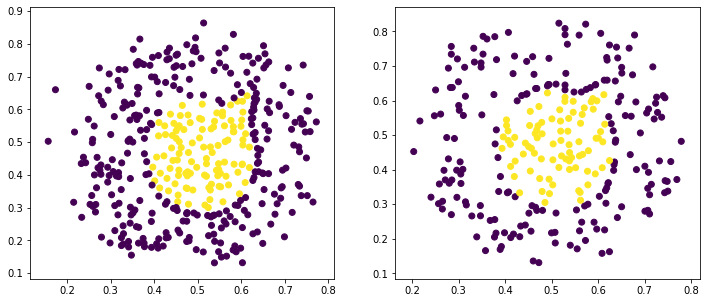

In [216]:
fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.scatter(x_train[_X], x_train[_Y], c=y_train)

fig.add_subplot(122)

plt.scatter(x_valid[_X], x_valid[_Y], c=y_valid)
plt.show()

In [11]:
train_ds = TD(T(x_train), T(y_train))
train_dl = DL(train_ds, batch_size=64, shuffle=True)

valid_ds = TD(T(x_valid), T(y_valid))
valid_dl = DL(valid_ds, batch_size=64, shuffle=False)

In [47]:
class NN(nn.Module):
    
    def __init__(self, num_hyperplanes):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(2, num_hyperplanes),
            nn.Sigmoid(),
            nn.Linear(num_hyperplanes, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, xb):
        xb = self.main(xb)
        return xb.view(-1)

In [48]:
def get_model(num_hyperplanes):
    nn = NN(num_hyperplanes)
    return nn, optim.Adam(nn.parameters(), lr=0.05)

## Train a neural network

In [49]:
from learner import Learner
from callbacks import CallbackHandler
from utility_callbacks import LossCallback, AccuracyCallback
from trainer import Trainer

In [50]:
model, opt = get_model(3)
loss = nn.BCELoss()
learn = Learner(train_dl, valid_dl, model, loss, opt)

loss_cb = LossCallback()
acc_cb = AccuracyCallback()
cb_handler = CallbackHandler(cbs=[loss_cb, acc_cb])

trainer = Trainer(learn=learn, cb_handler=cb_handler)

trainer.train(500)

## Plot loss and accuracy over epoch

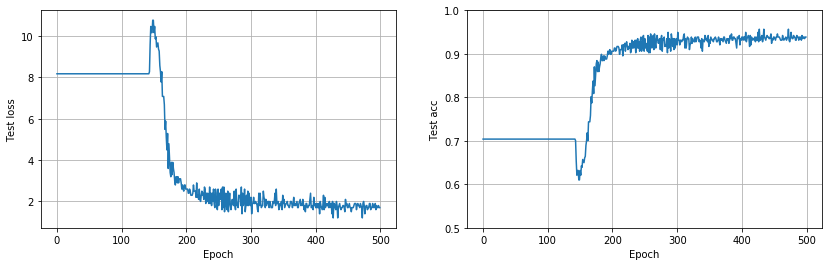

In [51]:
fig = plt.figure(figsize=(14, 4))

ax = fig.add_subplot(121)
loss_cb.plot()

fig.add_subplot(122)
acc_cb.plot()

plt.show()

## Visualize decision boundary

In [52]:
xs = np.linspace(start=0, stop=1, num=100)
ys = xs.copy()
xxs, yys = np.meshgrid(xs, ys)
xxs, yys = xxs.flatten(), yys.flatten()
xxs.shape, yys.shape

((10000,), (10000,))

In [53]:
grid = np.hstack([xxs.reshape(-1, 1), yys.reshape(-1, 1)])
grid = T(grid)
grid.size()

torch.Size([10000, 2])

In [54]:
grid_values = model(grid.float()).detach().numpy()
grid_values.shape

(10000,)

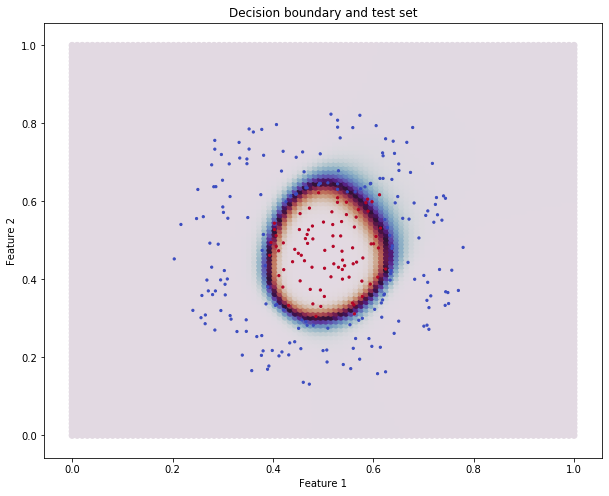

In [55]:
plt.figure(figsize=(10, 8))
plt.scatter(grid[X], grid[Y], c=grid_values, cmap='twilight')
plt.scatter(x_valid[X], x_valid[Y], c=y_valid, s=5, cmap='coolwarm')
plt.title('Decision boundary and test set')
plt.xlabel('Feature 1'); plt.ylabel('Feature 2')
plt.show()

## Deconstruct decision boundary

In [186]:
l1_weights, l1_biases, l2_weights, l2_biases = list(model.parameters())
l1_weights, l1_biases, l2_weights, l2_biases = map(lambda var : var.detach().numpy(), [
    l1_weights, l1_biases, l2_weights, l2_biases
])

In [190]:
X = xxs.reshape(100, 100)
Y = yys.reshape(100, 100)

In [191]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [192]:
def get_activations(neuron_index):
    w1, w2 = l1_weights[neuron_index-1]
    w0 = l1_biases[neuron_index-1]
    Z = sigmoid(w1 * X + w2 * Y + w0)
    return Z

In [193]:
Z1 = get_activations(1)
Z2 = get_activations(2)
Z3 = get_activations(3)

In [194]:
w1, w2, w3 = l2_weights[0]
w0 = l2_biases

In [243]:
def plot_wireframe(X, Y, Z, title, ylabel, ax):
    
    ax.plot_wireframe(X, Y, Z, alpha=0.2)
    ax.contourf(X, Y, Z, zdir='z', offset=Z.min(), cmap=cm.twilight)
    
    ax.scatter(x_valid[_X], x_valid[_Y], zs=Z.min(), s=1, c=y_valid, cmap='viridis')
    
    ax.set_xlabel('Feature 1'); ax.set_ylabel('Feature 2'); ax.set_zlabel(ylabel)
    ax.set_title(title)
    ax.set_xlim(0, 1); ax.set_ylim(0, 1); ax.set_zlim(Z.min(), Z.max())

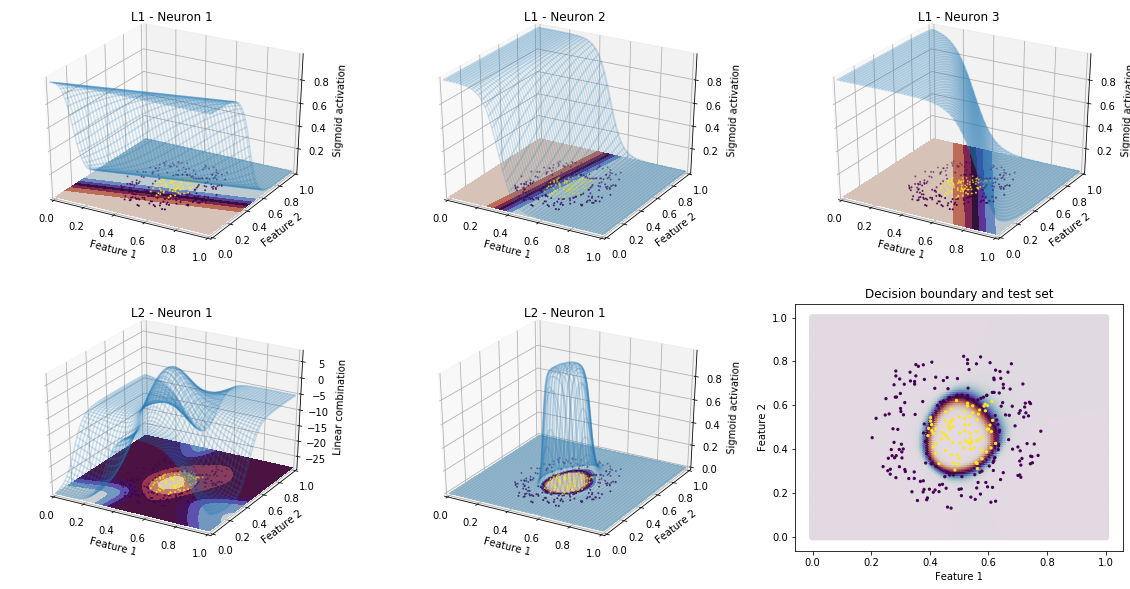

In [244]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(231, projection='3d')
plot_wireframe(X, Y, Z1, 'L1 - Neuron 1', 'Sigmoid activation', ax)

ax = fig.add_subplot(232, projection='3d')
plot_wireframe(X, Y, Z2, 'L1 - Neuron 2', 'Sigmoid activation', ax)

ax = fig.add_subplot(233, projection='3d')
plot_wireframe(X, Y, Z3, 'L1 - Neuron 3', 'Sigmoid activation', ax)

l2_linear_combination = w0 + w1 * Z1 + w2 * Z2 + w3 * Z3

ax = fig.add_subplot(234, projection='3d')
plot_wireframe(X, Y, l2_linear_combination, 'L2 - Neuron 1', 'Linear combination', ax)

ax = fig.add_subplot(235, projection='3d')
plot_wireframe(X, Y, sigmoid(l2_linear_combination), 'L2 - Neuron 1', 'Sigmoid activation', ax)

fig.add_subplot(236)
plt.scatter(grid[_X], grid[_Y], c=grid_values, cmap='twilight')
plt.scatter(x_valid[_X], x_valid[_Y], c=y_valid, s=5, cmap='viridis')
plt.title('Decision boundary and test set')
plt.xlabel('Feature 1'); plt.ylabel('Feature 2')

plt.show()

- Post bishop screenshot 129 here.
- Threshold unit 2 layer can do this convex task too. Not trainable. Last layer has to have no activation function.
- Testing for the idea of a heuristic proof for a sigmoid network with 3 layers. The idea of local basis function networks (see row 2 col 2 picture).
- Less obvious is that a sigmoid with 2 layers can also do this. (do this in another notebook, with the proof, and how a sigmoid can approximate both a linear unit well and a step function.